<a href="https://colab.research.google.com/github/tayrone/tidy_tuesday_python/blob/main/fishing_210608.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


sns.set_style("whitegrid")
#plt.rcParams['figure.figsize'] = [14, 4]

%load_ext google.colab.data_table
from google.colab import data_table as dt


In [2]:
fishing = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/'\
                      'tidytuesday/master/data/2021/2021-06-08/fishing.csv')

fishing = fishing[fishing.year > 1925]

## Exploratory Data Analysis

In [3]:
fishing_sum = (fishing
               .groupby(['year', 'lake'])[['values']]
               .sum())

No handles with labels found to put in legend.


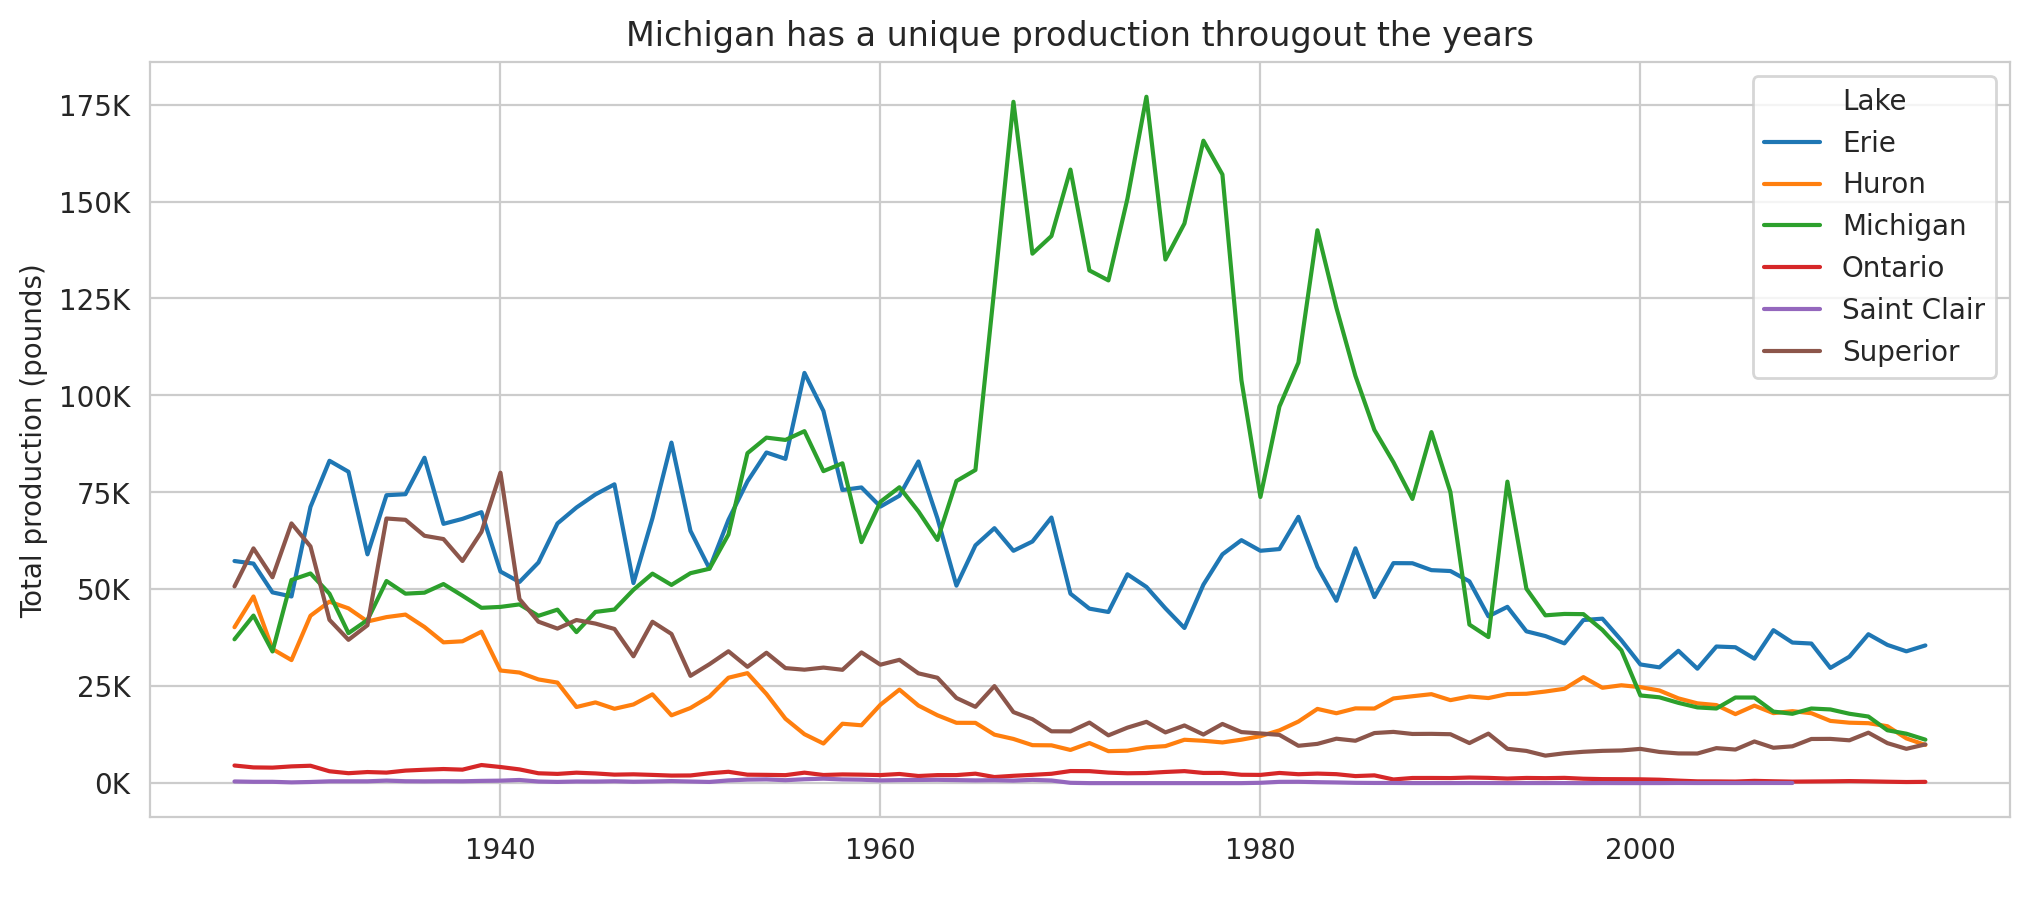

In [4]:
plt.figure(figsize = (12, 5), dpi = 200)
sns.set_style("whitegrid")

plt.ticklabel_format(style = 'sci', axis = 'y')
plt.title('Michigan has a unique production througout the years')
plt.ylabel('Total production (pounds)')
plt.xlabel(' ')
plt.legend(title = 'Lake')

# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax = sns.lineplot(x = 'year', y = 'values', data = fishing_sum, hue = 'lake',)

ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))

ax.legend(title = 'Lake')
plt.show(ax)


It is not feasible to analyze the behaviour of each species on each lake:

In [5]:
len(fishing
    .groupby(['year', 'lake', 'species'])
    .sum())

8682

In [6]:
grand_total = fishing.groupby(['species', 'year']).first()

grand_total = grand_total.reset_index()[['species', 'year', 'grand_total']]

grand_total = grand_total.dropna()



In [7]:
species_max = (grand_total
              .groupby(['species'])['grand_total']
              .max()
              .to_frame())

species_max.columns = ['species_max']



In [8]:
grand_total = grand_total.merge(species_max, on = 'species')

grand_total = grand_total[grand_total.species_max > 10000]

grand_total = grand_total.reset_index()[['year', 'species', 'grand_total']]


In [9]:
year_total = (grand_total
             .groupby(['year'])[['grand_total']]
             .sum())

year_total[['species']] = "Total"

year_total = year_total.reset_index()[['year', 'species', 'grand_total']]


In [10]:
grand_total = grand_total.append(year_total, ignore_index = True)

No handles with labels found to put in legend.


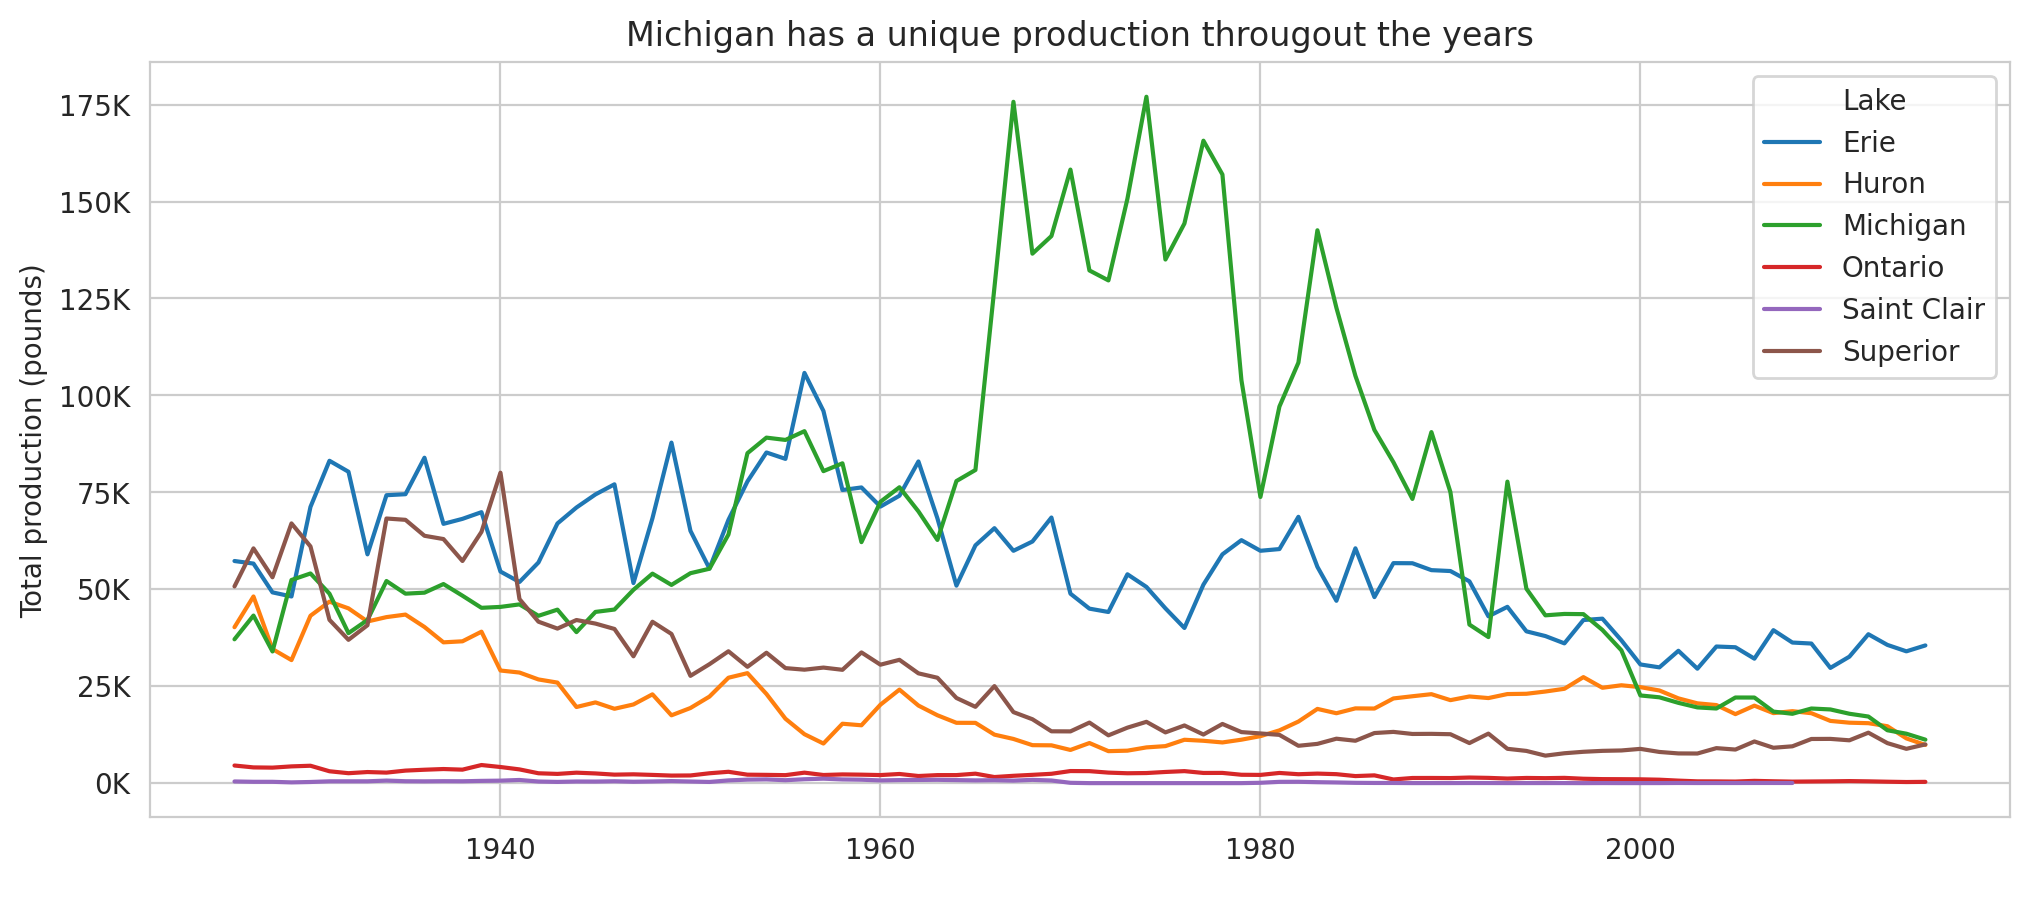

In [11]:
plt.figure(figsize = (12, 5), dpi = 200)

plt.ticklabel_format(style = 'sci', axis = 'y')
plt.title('Michigan has a unique production througout the years')
plt.ylabel('Total production (pounds)')
plt.xlabel(' ')
plt.legend(title = 'Lake')

# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

ax = sns.lineplot(x = 'year', y = 'values', data = fishing_sum, hue = 'lake')

ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))

ax.legend(title = 'Lake')
plt.show(ax)

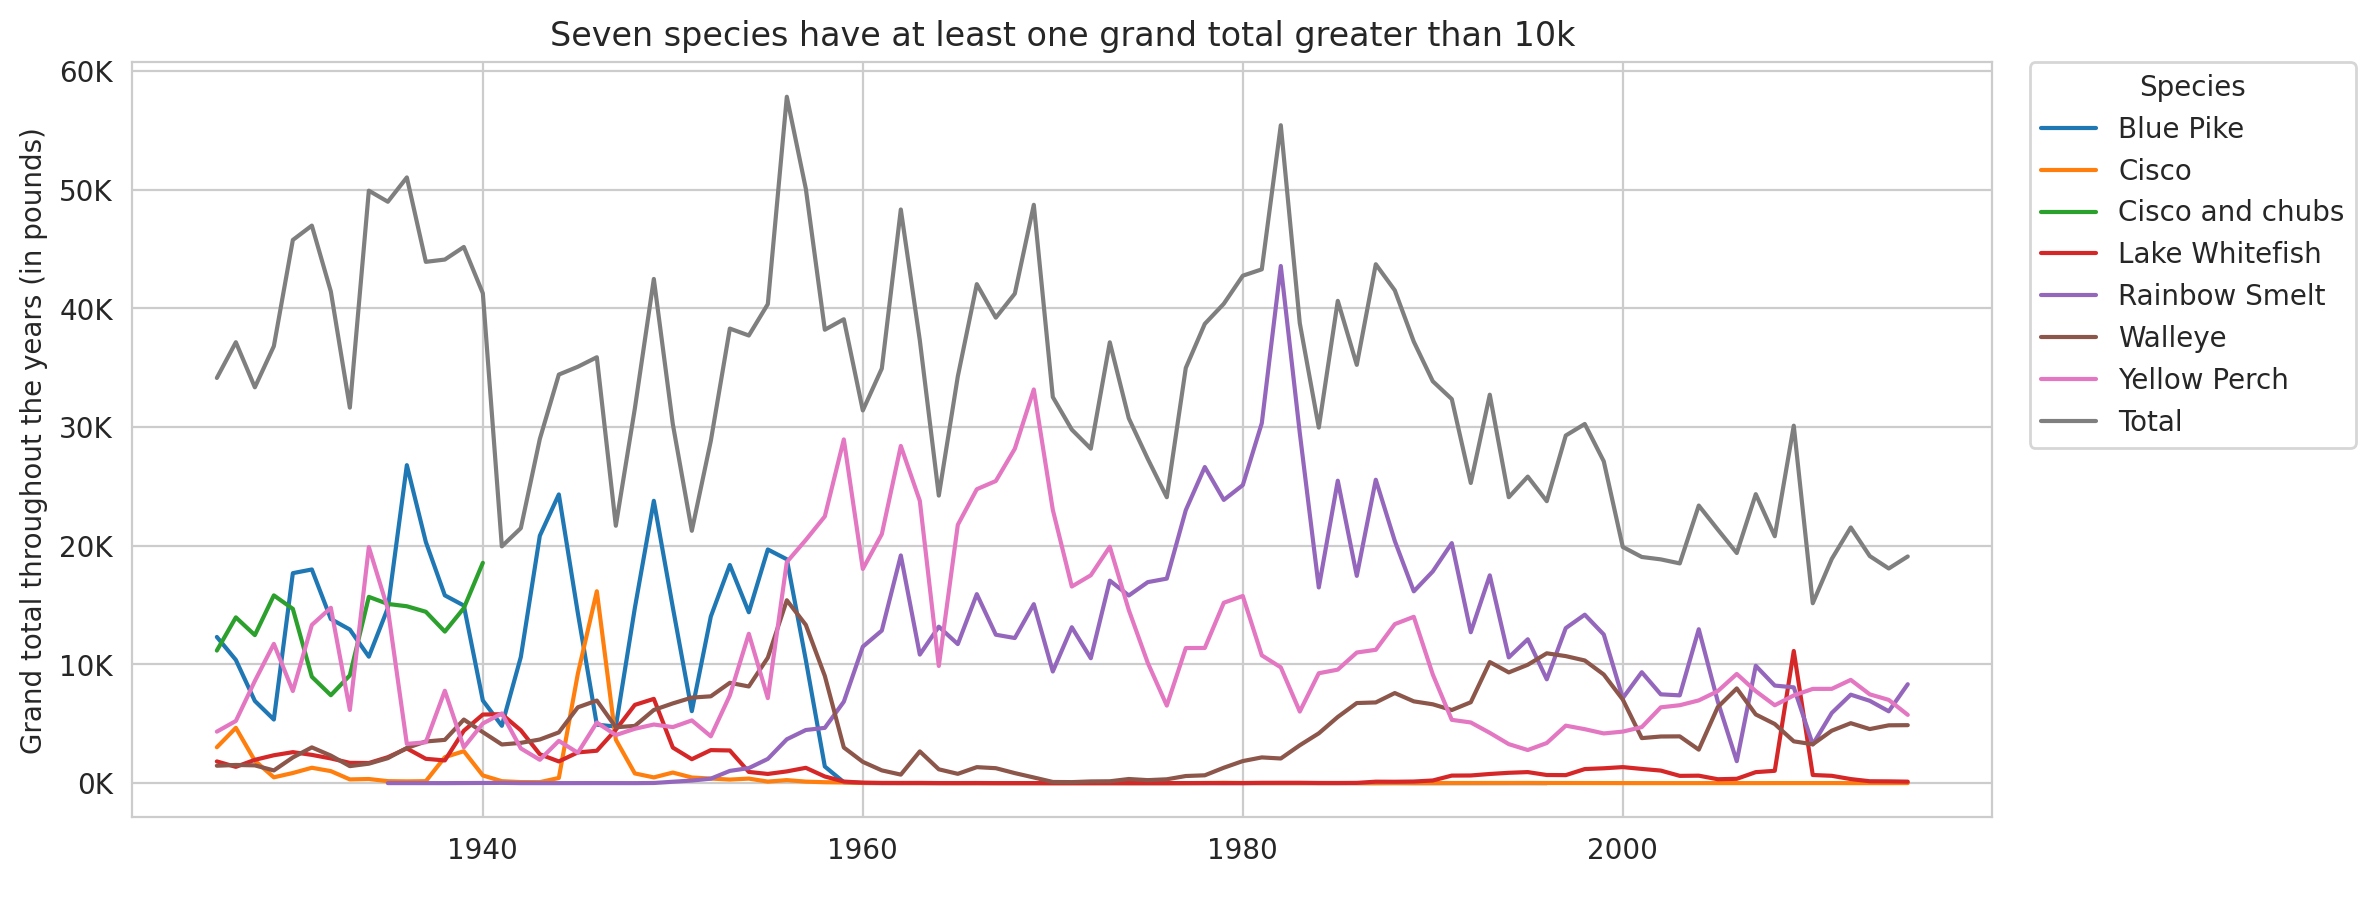

In [12]:
plt.figure(figsize = (12, 5), dpi = 200)

plt.ticklabel_format(style = 'sci', axis = 'y')
plt.title('Seven species have at least one grand total greater than 10k')
plt.ylabel('Grand total throughout the years (in pounds)')
plt.xlabel(' ')

ax = sns.lineplot(x = 'year', y = 'grand_total', 
                  data  = grand_total, hue = 'species')

ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))

plt.legend(title = 'Species', 
           bbox_to_anchor = (1.02, 1), loc = 2, borderaxespad = 0.)


# Modeling

Let’s try to predict the U.S. total production based on the production of Ohio only. 
The next two plots represent the data used on the model.

In [13]:
us_total_production = (fishing[fishing.region == 'U.S. Total']
                      .groupby(['year'])['values']
                      .sum()
                      .to_frame())

us_total_production.columns = ['us_total_production']

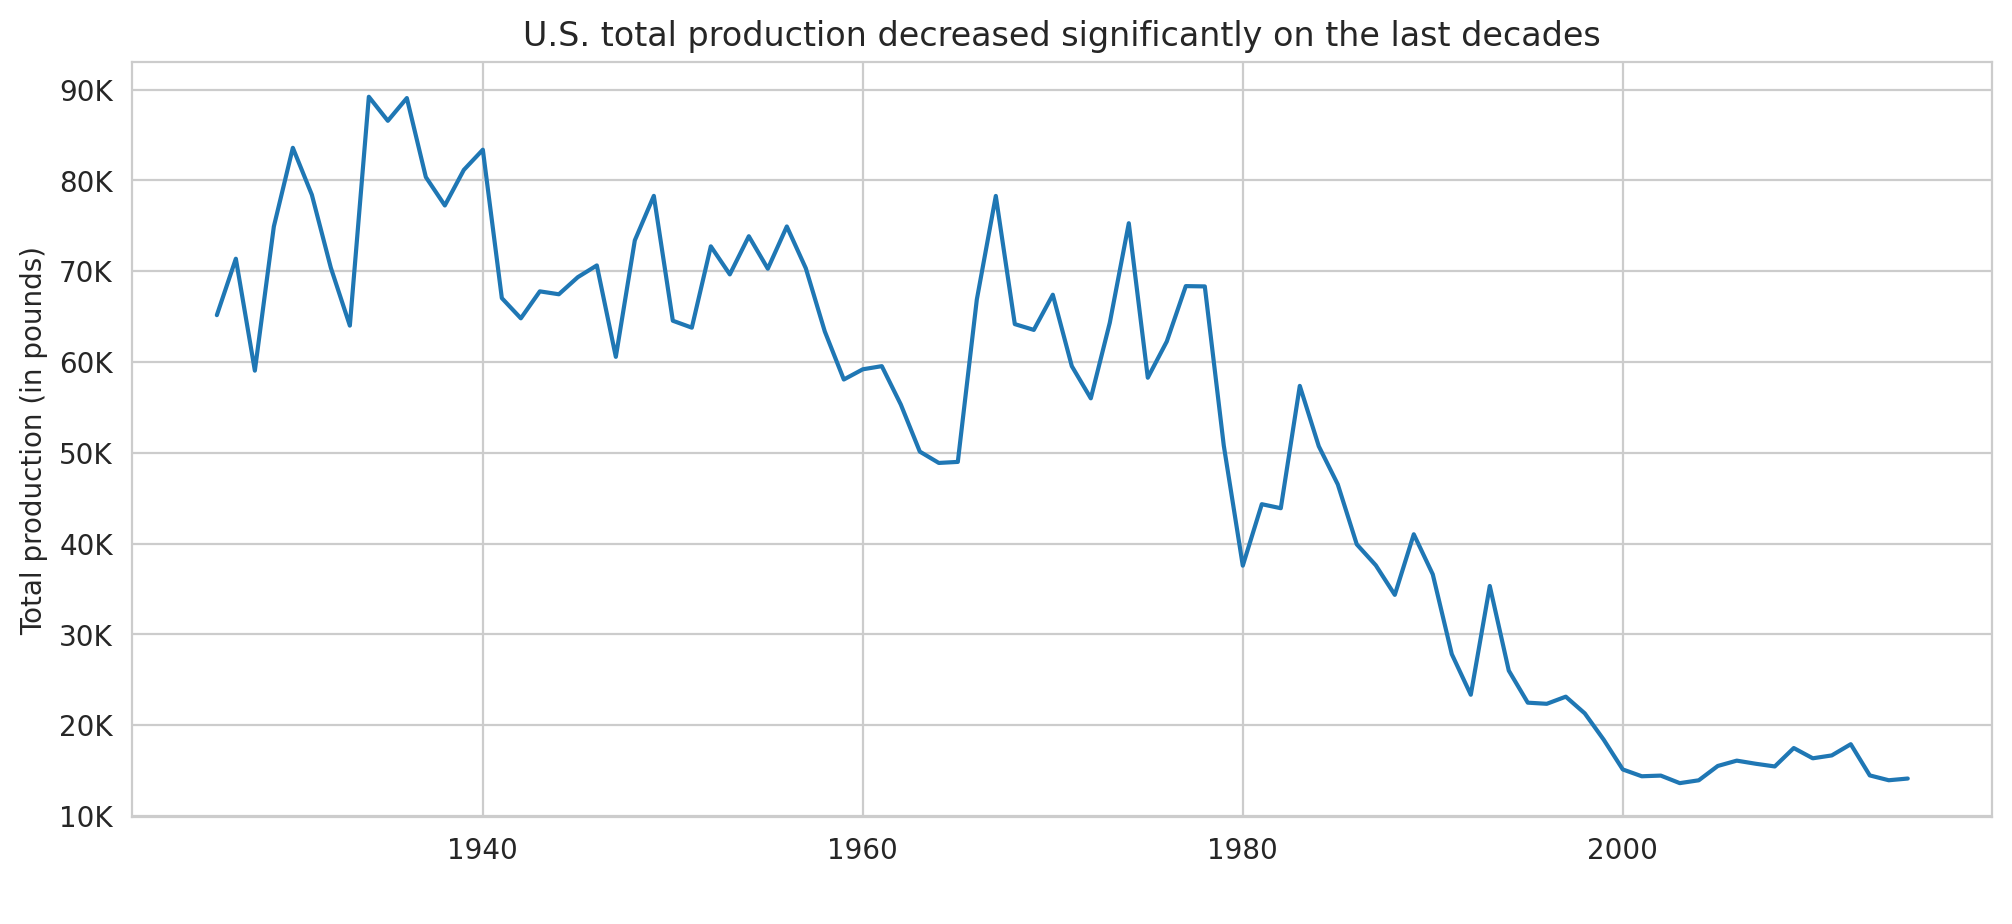

In [14]:
plt.figure(figsize = (12, 5), dpi = 200)

plt.ticklabel_format(style = 'sci', axis = 'y')
plt.title('U.S. total production decreased significantly on the last decades')
plt.ylabel('Total production (in pounds)')
plt.xlabel(' ')

ax = sns.lineplot(x = 'year', y = 'us_total_production', 
                  data = us_total_production)

ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))


In [83]:
region_production = (fishing
                    .groupby(['year', 'region'])['values']
                    .sum()
                    .to_frame()
                    .reset_index())

region_production.rename(columns = {'values':'region_production'}, inplace = True)


In [16]:
region_max_production = (region_production
                        .groupby(['region'])['region_production']
                        .max()
                        .to_frame())

region_max_production.columns = ['region_max']

region_min_production = (region_production
                        .groupby(['region'])['region_production']
                        .min()
                        .to_frame())

region_min_production.columns = ['region_min']


In [17]:
region_max_min = region_max_production.merge(region_min_production, 
                                             on = 'region')


In [84]:
region_production = region_production.merge(region_max_min, on = "region")

region_production = region_production[region_production.region_max > 10000]
region_production = region_production[region_production.region_min > 0]


region_production.drop(columns = ['region_max', 'region_min'], inplace = True)


In [85]:
region_production = region_production.pivot(columns = 'region', 
                                            values = 'region_production',
                                            index = 'year')

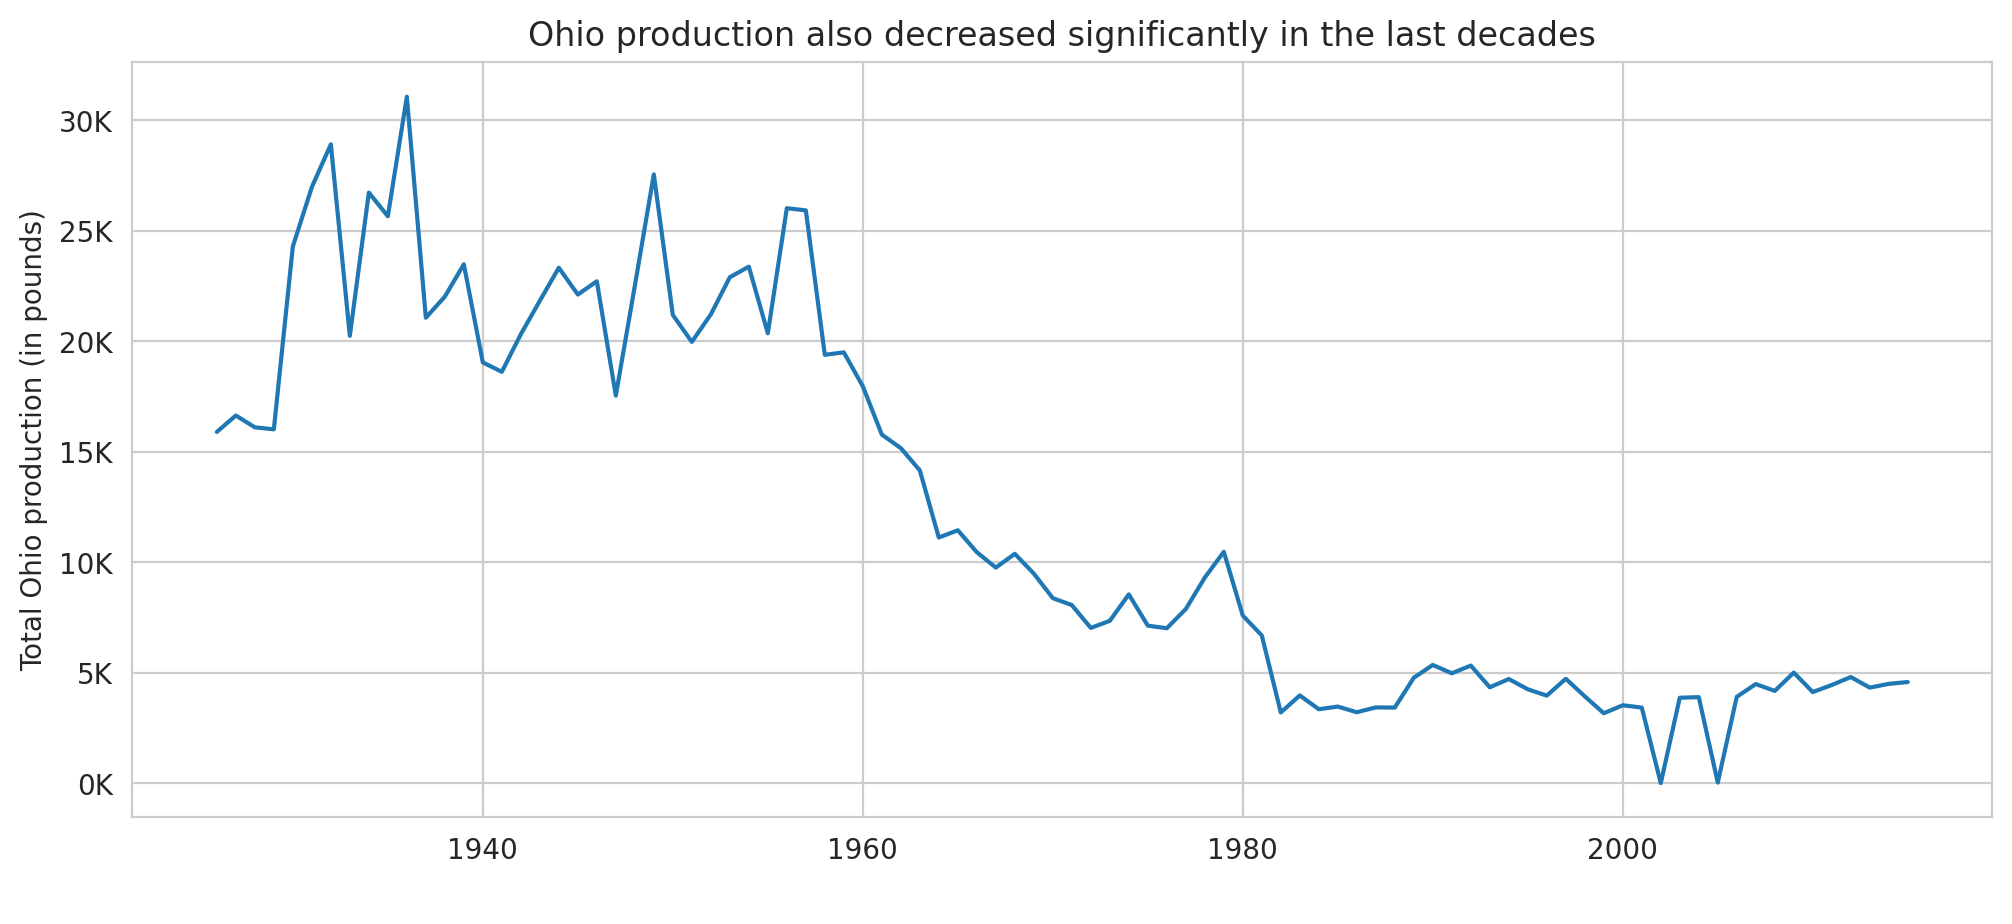

In [20]:
plt.figure(figsize = (12, 5), dpi = 200)

plt.title('Ohio production also decreased significantly in the last decades')
plt.ylabel('Total Ohio production (in pounds)')
plt.xlabel(' ')

ax = sns.lineplot(x = 'year', y = 'Ohio (OH)', data = region_production)

ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))

We can also see how other regions total production are distributed:

In [21]:
melted_region_production = pd.melt(region_production.reset_index(), id_vars = 'year', 
                            value_vars = region_production.columns,
                            value_name = 'year_production')


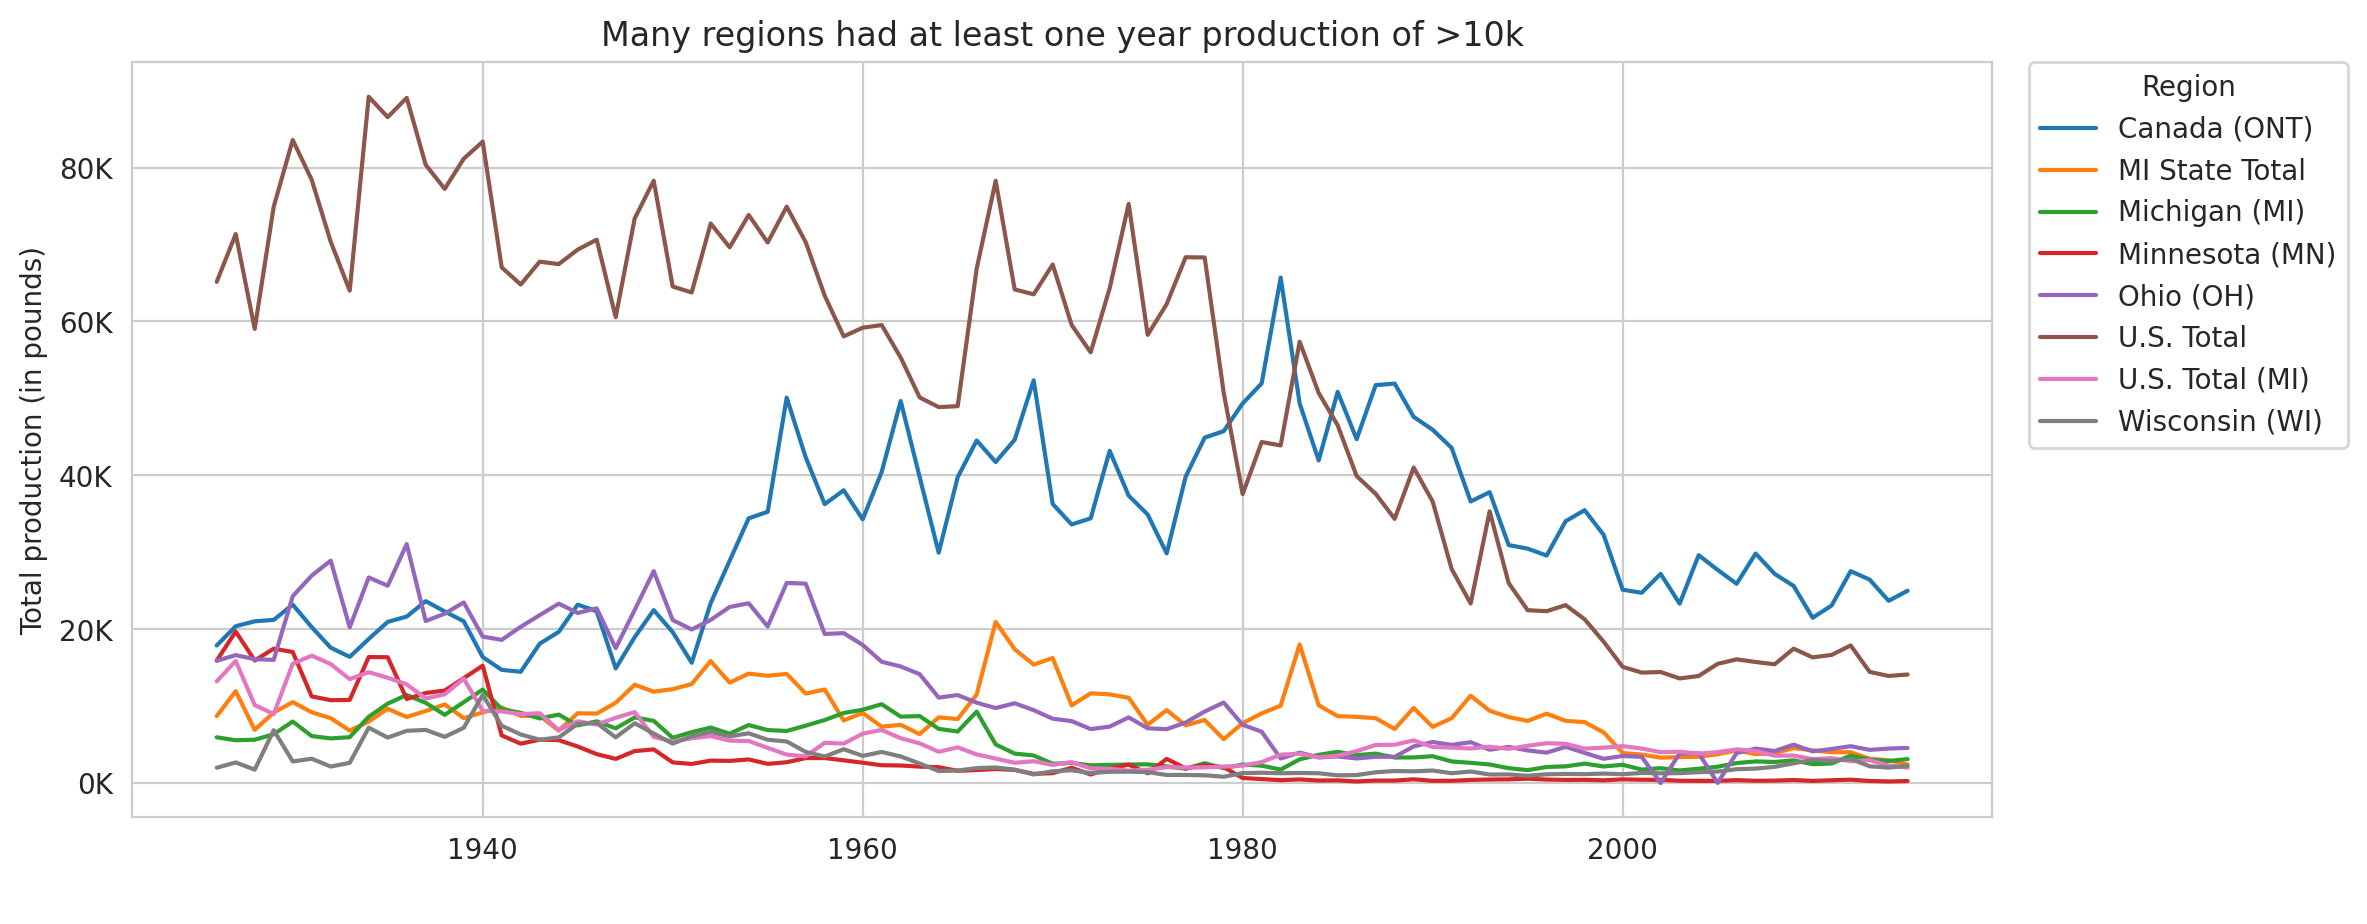

In [22]:
plt.figure(figsize = (12, 5), dpi = 200)

plt.title('Many regions had at least one year production of >10k')
plt.ylabel('Total production (in pounds)')
plt.xlabel(' ')

ax = sns.lineplot(x = 'year', y = 'year_production', hue = 'region',
                  data = melted_region_production)

ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))

plt.legend(title = 'Region', 
           bbox_to_anchor = (1.02, 1), loc = 2, borderaxespad = 0.)

By now, let’s try to predict the total U.S. production by using Ohio production as a predictor. At first, let’s split the data on training and testing sets.

In [23]:
train_production, test_production = train_test_split(region_production, 
                                                      test_size = 0.33)

In [24]:
regr = LinearRegression()

In [25]:
train_ohio = train_production['Ohio (OH)'].to_frame()
train_total = train_production['U.S. Total'].to_frame()

In [26]:
regr.fit(train_ohio, train_total)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [27]:
test_ohio = test_production['Ohio (OH)'].to_frame()
test_total = test_production['U.S. Total'].to_frame()

In [28]:
total_pred = regr.predict(test_ohio)

In [29]:
print('Coefficients: \n', regr.coef_)

Coefficients: 
 [[2.23729642]]


In [53]:
print('Mean squared error: %.2f'
      % mean_squared_error(test_total, total_pred, squared = False))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(test_total, total_pred))

print('Mean absolute error: %.2f'
      % mean_absolute_error(test_total, total_pred))

Mean squared error: 14107.87
Coefficient of determination: 0.63
Mean absolute error: 12159.52


In [31]:
test_data = test_ohio.merge(test_total, on = 'year')
train_data = train_ohio.merge(train_total, on = 'year')

test_data['total_pred'] = total_pred

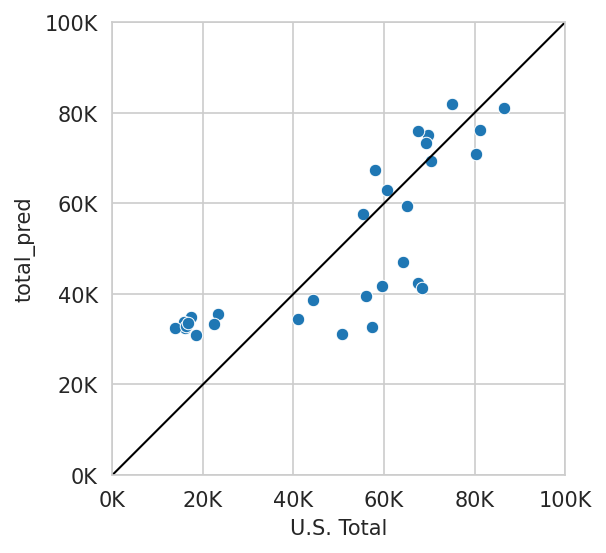

In [44]:
plt.figure(figsize = (4, 4), dpi = 150)

ax = sns.scatterplot(x = 'U.S. Total', y = 'total_pred', data = test_data)

ax.plot([0,100000],[0,100000], 'black', linewidth = 1)

sns.lineplot()

plt.axis('square')

plt.xlim(0, 100000)
plt.ylim(0, 100000)
plt.gca().set_aspect('equal', adjustable = 'box')
plt.draw()

ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))

ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))

In [ ]:
'''
plt.figure(figsize = (12, 5), dpi = 200)


ax = sns.scatterplot(x = 'Ohio (OH)', y = 'U.S. Total', 
                data = test_data, color = 'black')

sns.lineplot(x = 'Ohio (OH)', y = 'total_pred', data = test_data)
#ax = plt.plot(test_ohio, total_pred, color = 'blue', linewidth = 3)

#plt.axis('equal')

ax.yaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))

ax.xaxis.set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
    
'''

Some regions fit the requirement of having least one production of >10k, but present data starting only at 1953. Let’s try using them on our model to see if they have a good impact.

In [77]:
train_input = fishing[fishing.year >= 1953]

train_input['region_production'] = (train_input
                                    .groupby(['year', 'region'])['values']
                                    .sum()
                                    .reset_index()
                                    .values)

'''

region_max_production = (train_input
                         .reset_index()
                         .groupby(['region'])['region_production']
                         .max())

train_input = train_input[region_max_production > 10000]

train_input = train_input.pivot(columns = 'region', 
                                values = 'region_production')


'''

ValueError: ignored